In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

class Agent(object):
    def __init__(self):
        
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.node_num = 12
        self.actor_lr = 0.01
        self.critic_lr = 0.01
        self.actor = self.build_actor()
        self.critic = self.build_critic()
        
        self.discount_rate = 0.95
        self.penalty = -10
        
        self.episode_num = 500
        
        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

    #(1) 정책네트워크 생성
    def build_actor(self):
        input_states = Input(shape=(self.state_size,), name='input_states')
        x = Dense(self.node_num, activation='tanh')(input_states)
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)

        model = tf.keras.models.Model(inputs=input_states, outputs=out_actions)
        model.compile(optimizer=Adam(learning_rate=self.actor_lr))
        model.summary()
        return model

    #(2) 가치네트워크 생성
    def build_critic(self):
        input_states = Input(shape=(self.state_size,), name='input_states')
        x = Dense(self.node_num, activation='tanh')(input_states)
        out_value = Dense(1, activation='linear', name='value')(x)

        model = tf.keras.models.Model(inputs=input_states, outputs=out_value)
        model.compile(optimizer=Adam(learning_rate=self.critic_lr), loss='mean_squared_error')
        model.summary()
        return model

    def train(self):
        #(1) 에피소드 반복 학습 시작
        for episode in range(self.episode_num):
            state, _ = self.env.reset()
            reward_tot = 0
            step_count = 0
            done = False

            states = []
            actions = []
            rewards = []

            while not done:
                step_count += 1
                #(2) 상태 기반 행동 선택 및 환경과 상호작용
                state_input = np.reshape(state, [1, self.state_size]).astype(np.float32)
                policy = self.actor(state_input, training=False).numpy()[0]
                action = np.random.choice(self.action_size, p=policy)

                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                if done and step_count < 499:
                    reward = self.penalty

                #(3) 학습을 위한 데이터 수집
                action_onehot = np.zeros(self.action_size)
                action_onehot[action] = 1.0

                states.append(state)
                actions.append(action_onehot)
                rewards.append(reward)

                reward_tot += reward
                state = next_state
                
            #(4) 에피소드 리워드와 이동 평균 기록
            self.reward_list.append(reward_tot - self.penalty)
            self.count_list.append(step_count)
            self.moving_avg_list.append(np.mean(self.reward_list[-self.moving_avg_size:]))

            #(5) 수집된 데이터를 바탕으로 모델 업데이트
            self.update_model(states, actions, rewards)

            #(6) 주기적인 로그 출력
            if episode % 10 == 0:
                moving_avg = np.mean(self.reward_list[-self.moving_avg_size:])
                reward_avg = np.mean(self.reward_list)
                print(f"episode:{episode}, moving_avg:{moving_avg:.2f}, rewards_avg:{reward_avg:.2f}")

        #(7) 학습 완료 후 모델 저장
        self.save_model()

    def update_model(self, states, actions, rewards):
        #(1) 상태, 행동, 보상 데이터를 넘파이 배열로 변환
        states = np.array(states, dtype=np.float32)
        actions = np.array(actions, dtype=np.float32)

        #(2) 누적 할인 보상 계산
        returns = self.make_discount_rewards(rewards)

        #(3) 현재 상태에 대한 가치 예측
        values = self.critic(states).numpy().flatten()

        #(4) 어드밴티지(Advantage) 계산
        advantages = returns - values

        #(5) 어드밴티지 정규화
        advantages -= np.mean(advantages)
        advantages /= (np.std(advantages) + 1e-8)

        #(6) 신경망 업데이트
        self.update_actor(states, actions, advantages)
        self.update_critic(states, returns)

    def make_discount_rewards(self, rewards):
        #(1) 출력 배열 초기화
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)

        #(2) 누적 보상 초기값 설정 
        cumulative = 0.0

        #(3) 역순 반복을 통한 할인 보상 계산
        for i in reversed(range(len(rewards))):
            cumulative = cumulative * self.discount_rate + rewards[i]
            discounted_rewards[i] = cumulative
        #(4) 할인된 보상 배열 반환
        return discounted_rewards

    def update_actor(self, states, actions, advantages):
        #(1) 자동 미분 설정
        with tf.GradientTape() as tape:
            #(2) 정책 신경망을 통한 행동 확률 분포 예측
            probs = self.actor(states, training=True)

            #(3) 실제로 선택한 행동에 해당하는 확률만 추출
            selected_probs = tf.reduce_sum(probs * actions, axis=1)

            #(4) 손실 함수 계산
            loss = -tf.reduce_mean(tf.math.log(selected_probs + 1e-8) * advantages)

        #(5) 그래디언트 계산
        gradients = tape.gradient(loss, self.actor.trainable_variables)

        #(6) 옵티마이저를 통한 가중치 업데이트
        self.actor.optimizer.apply_gradients(zip(gradients, self.actor.trainable_variables))

    def update_critic(self, states, returns):
        with tf.GradientTape() as tape:
            #(1) 현재 상태에 대한 가치 예측
            values = self.critic(states, training=True)
            values = tf.squeeze(values, axis=1)  # (배치, 1) → (배치,)

            #(2) 손실 함수 계산: 평균 제곱 오차(MSE)
            loss = tf.reduce_mean(tf.square(returns - values))  # MSE 손실
            
        gradients = tape.gradient(loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(gradients, self.critic.trainable_variables))
    
    def save_model(self):
        os.makedirs("./model", exist_ok=True)
        self.actor.save("./model/a2c_actor.keras")
        self.critic.save("./model/a2c_critic.keras")
        print("*****end learning")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 12)                60        
                                                                 
 output (Dense)              (None, 2)                 26        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 12)         

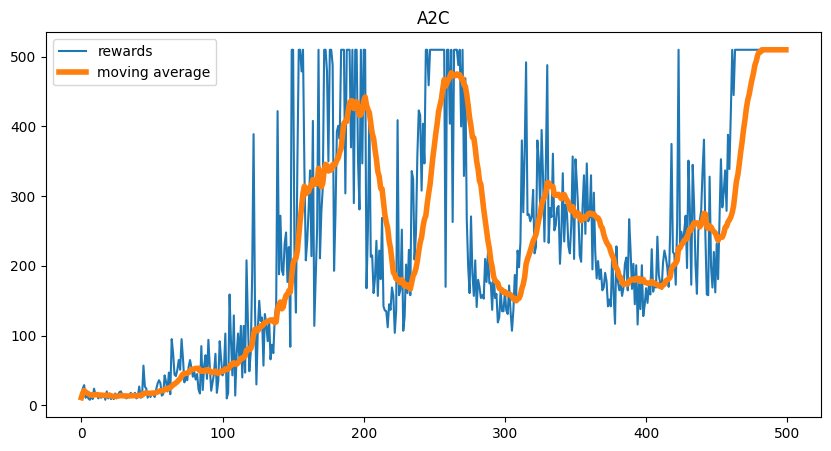

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('A2C')
plt.show()